In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [119]:
from data_processing.start_experiment import *
from data_processing.read_data import *
from data_processing.gaussian import *
from sklearn import tree

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
import GPy
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
import time

## Read in Data

In [5]:
parameter_list = ['season_duration', 'gamma', 'mut_rate', 'T', 'target_area', 'gradnoise']

In [8]:
parameter_space = ParameterSpace([DiscreteParameter('season_duration',list(range(100,1001,10))), 
                                 DiscreteParameter('gamma',list(range(0,25))), 
                                 ContinuousParameter('mut_rate',0,0.5),
                                 ContinuousParameter('T',1,100),
                                 DiscreteParameter('target_area',list(range(1,101))),
                                 ContinuousParameter('gradnoise',0.25,0.99)])

In [9]:
num_experiments = 100

In [10]:
file_names = ["latin/latin_{}.par".format(i) for i in range(num_experiments)]
data_files = ["latin/data_cellcount_{}.txt".format(i) for i in range(num_experiments)]

In [11]:
X = get_parameter_array(file_names,parameter_list)

# Some files have no data; don't get those
unrun_files = get_no_data(data_files) 
X_no_data = X[unrun_files,:]

X = np.delete(X,unrun_files,axis=0)

In [127]:
X_no_data

array([[860.    ,   9.    ,   0.1325,  33.175 ,   7.    ,   0.7939],
       [920.    ,  12.    ,   0.4425,  10.405 ,  18.    ,   0.8975],
       [600.    ,  16.    ,   0.1475,  56.935 ,  13.    ,   0.5275],
       [480.    ,   5.    ,   0.3725,  63.865 ,  17.    ,   0.5201],
       [350.    ,   6.    ,   0.4775,  19.315 ,  11.    ,   0.6977],
       [290.    ,   8.    ,   0.3925,  29.215 ,  20.    ,   0.6903],
       [640.    ,   4.    ,   0.0975,  22.285 ,  26.    ,   0.3277],
       [980.    ,   5.    ,   0.2275,   9.415 ,  23.    ,   0.8827],
       [940.    ,  15.    ,   0.0875,  74.755 ,  16.    ,   0.9567],
       [820.    ,  11.    ,   0.3175,  99.505 ,  21.    ,   0.6237],
       [890.    ,  15.    ,   0.2775,  30.205 ,  22.    ,   0.2981],
       [820.    ,  22.    ,   0.4875,  69.805 ,  19.    ,   0.6459],
       [330.    ,   8.    ,   0.1575,  18.325 ,  14.    ,   0.9271]])

In [126]:
unrun_files

[3, 18, 44, 45, 53, 55, 60, 67, 76, 92, 94, 95, 97]

In [17]:
np.mean(X,axis=0)

array([529.65517241,  12.22988506,   0.24577586,  51.8712069 ,
        55.43678161,   0.61162184])

In [18]:
np.mean(X_no_data,axis=0)

array([686.15384615,  10.46153846,   0.27826923,  41.32346154,
        17.46153846,   0.67606923])

In [30]:
all_X = np.concatenate([X,X_no_data])

In [31]:
Y = np.concatenate([np.zeros((len(X),1)),np.ones((len(X_no_data),1))])

## Train a simple GP to predict whether run finishes

In [118]:
clf = tree.DecisionTreeClassifier()
clf.fit(all_X,Y)

DecisionTreeClassifier()

[Text(334.8, 605.7257142857143, 'X[4] <= 26.5\ngini = 0.226\nsamples = 100\nvalue = [87, 13]'),
 Text(279.0, 512.537142857143, 'X[4] <= 10.5\ngini = 0.5\nsamples = 26\nvalue = [13, 13]'),
 Text(167.4, 419.34857142857146, 'X[2] <= 0.165\ngini = 0.18\nsamples = 10\nvalue = [9, 1]'),
 Text(111.60000000000001, 326.16, 'X[1] <= 15.0\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(55.800000000000004, 232.9714285714286, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(167.4, 232.9714285714286, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(223.20000000000002, 326.16, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(390.6, 419.34857142857146, 'X[1] <= 2.5\ngini = 0.375\nsamples = 16\nvalue = [4, 12]'),
 Text(334.8, 326.16, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(446.40000000000003, 326.16, 'X[2] <= 0.067\ngini = 0.245\nsamples = 14\nvalue = [2, 12]'),
 Text(390.6, 232.9714285714286, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(502.20000000000005, 232.9714285714286, 'X[4] 

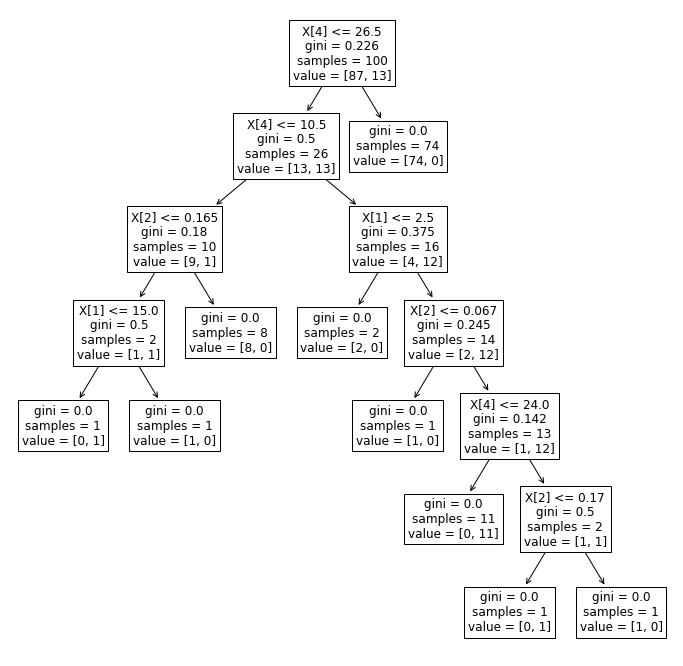

In [125]:
plt.figure(figsize=(12,12))
tree.plot_tree(clf,fontsize=12)

In [124]:
importances = clf.feature_importances_
sorted(list(zip(importances,parameter_list)),reverse=True)

[(0.6925797456301434, 'target_area'),
 (0.15788808892257167, 'gamma'),
 (0.14953216544728493, 'mut_rate'),
 (0.0, 'season_duration'),
 (0.0, 'gradnoise'),
 (0.0, 'T')]

In [114]:
emukit_model = GPyModelWrapper(GPy.models.GPClassification(all_X,Y,kernel=GPy.kern.RBF(X.shape[1], lengthscale=.01, variance=50)))

In [78]:
m = GPy.models.GPClassification(all_X,Y)

IndexError: invalid index to scalar variable.

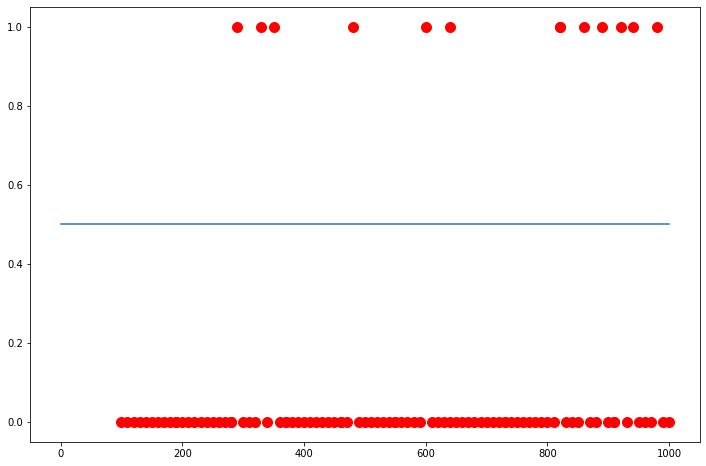

In [116]:
plot_gaussian_process(np.linspace(0,1000,1000),0,parameter_space,emukit_model)

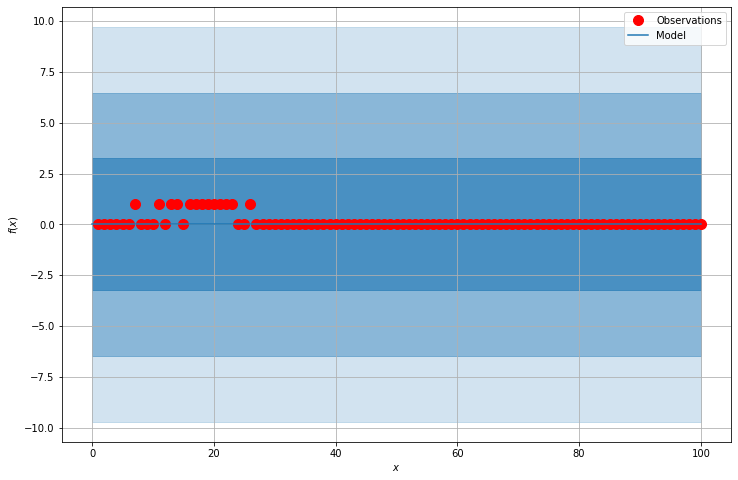

In [43]:
plot_gaussian_process(np.linspace(0,100),4,parameter_space,emukit_model)

In [44]:
get_sobol_indices(emukit_model,parameter_space)

({'season_duration': array([nan]),
  'gamma': array([nan]),
  'mut_rate': array([nan]),
  'T': array([nan]),
  'target_area': array([nan]),
  'gradnoise': array([nan])},
 {'season_duration': array([nan]),
  'gamma': array([nan]),
  'mut_rate': array([nan]),
  'T': array([nan]),
  'target_area': array([nan]),
  'gradnoise': array([nan])})

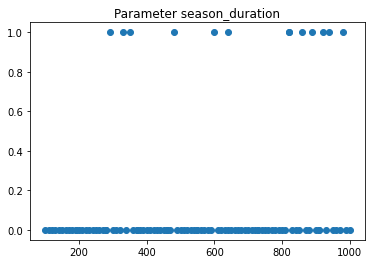

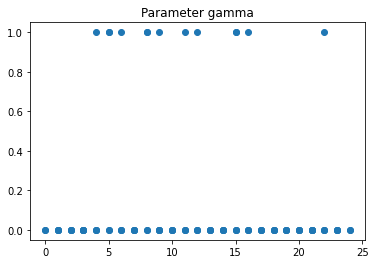

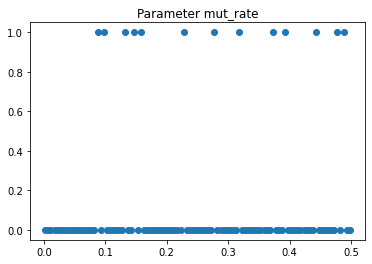

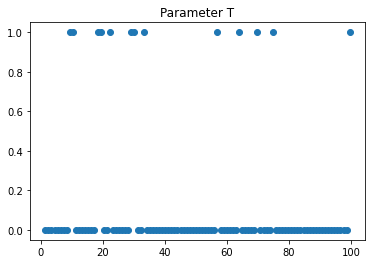

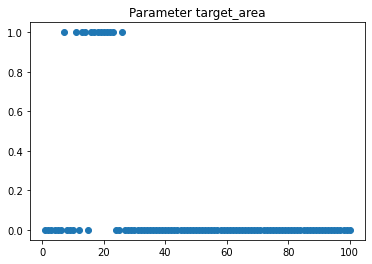

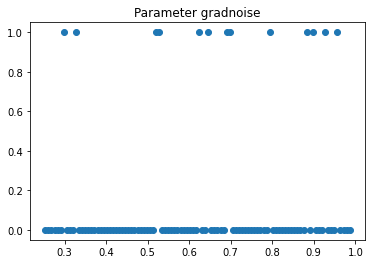

In [90]:
for i in range(X.shape[1]):
    plt.figure()
    plt.title("Parameter {}".format(parameter_list[i]))
    plt.scatter(all_X[:,i],Y)

What causes these runs to fail? First off, the issue occurs whenever seasons switch, as that's when cells tend to reproduce. Additionally, time switching only occurs on multiples of 25; if the length of a season isn't a multiple of 25, then the real season duration is LCM(25,season_duration). At the first instance of time-switching (which is LCM(25,season_duration)), these programs crash whenever the cell area is less than 30. The basic reason is that in the ReproduceWhoMadeIt3 function in dish.cpp line 1695, they have a hard constraint/check for whether cell areas are greater than 30; if not they don't reproduce/split, causing the function to loop infinitely. 